In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import keras
from keras.layers import Dense, LSTM, \
    Flatten, TimeDistributed, Conv2D, Dropout
from keras import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
dfs = [pd.read_csv('../input/heartbeat/mitbih_' + x + '.csv') for x in ['train', 'test']]
for df in dfs:
    df.columns = list(range(len(df.columns)))

In [7]:
data = pd.concat(dfs, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

data = data.rename({187: 'Label'}, axis=1)

In [5]:
data

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,Label
0,0.993311,1.000000,0.508361,0.093645,0.080268,0.160535,0.137124,0.127090,0.103679,0.127090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.948310,1.000000,0.604374,0.129225,0.035785,0.073559,0.079523,0.079523,0.079523,0.065606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.822222,0.602778,0.372222,0.225000,0.111111,0.052778,0.030556,0.002778,0.002778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.877235,0.419547,0.000000,0.191895,0.233611,0.164482,0.154946,0.169249,0.165673,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.814714,0.539510,0.433242,0.258856,0.155313,0.070845,0.046322,0.024523,0.040872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109439,1.000000,0.645533,0.092219,0.135447,0.138329,0.144092,0.135447,0.132565,0.135447,0.135447,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109440,0.985276,0.925153,0.825767,0.727607,0.487117,0.203681,0.024540,0.011043,0.015951,0.039264,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109441,0.964111,0.913540,0.326264,0.000000,0.216966,0.332790,0.313214,0.288744,0.288744,0.300163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109442,0.000000,0.036667,0.156667,0.241667,0.316667,0.371667,0.390000,0.425000,0.493333,0.553333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [75]:
len(data[data['Label']==5])

0

Text(0.5, 0, 'Time')

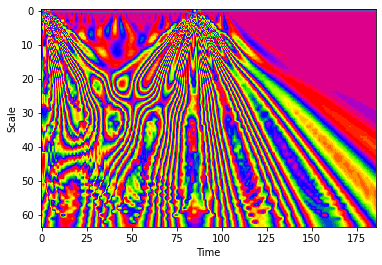

In [90]:
plt.plot(data.iloc[0,:-2])   # 0
scales = np.arange(1, 65) # range of scales
coeffs, freqs = pywt.cwt( data.iloc[0,:-2], scales, wavelet = "morl")
# create scalogram
plt.plot(figsize=(12,5))
plt.imshow(coeffs, cmap = 'prism', aspect = 'auto')
# plt.set_title(name)
# plt.spines['right'].set_visible(False)
# plt.spines['top'].set_visible(False)
plt.ylabel('Scale')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

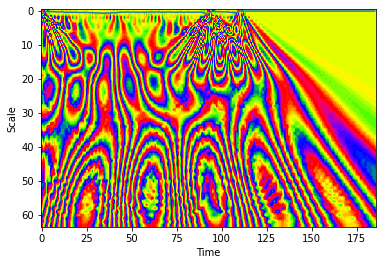

In [89]:
plt.plot(data.iloc[262,:-2]) # 1
scales = np.arange(1, 65) # range of scales
coeffs, freqs = pywt.cwt(data.iloc[262,:-2], scales, wavelet = "morl")
# create scalogram
plt.plot(figsize=(12,5))
plt.imshow(coeffs, cmap = 'prism', aspect = 'auto')
# plt.set_title(name)
# plt.spines['right'].set_visible(False)
# plt.spines['top'].set_visible(False)
plt.ylabel('Scale')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

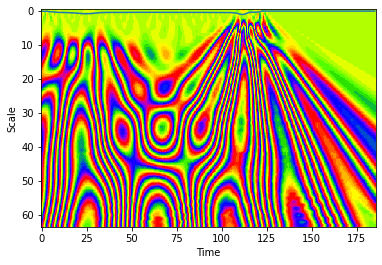

In [88]:
plt.plot(data.iloc[44,:-2])  # 2
scales = np.arange(1, 65) # range of scales
coeffs, freqs = pywt.cwt( data.iloc[44,:-2], scales, wavelet = "morl")
# create scalogram
plt.plot(figsize=(12,5))
plt.imshow(coeffs, cmap ='prism', aspect = 'auto')
# plt.set_title(name)
# plt.spines['right'].set_visible(False)
# plt.spines['top'].set_visible(False)
plt.ylabel('Scale')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

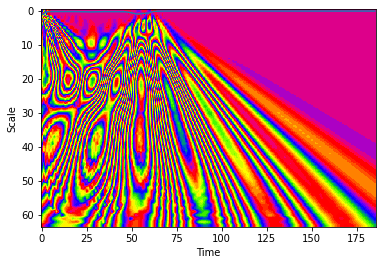

In [91]:
plt.plot(data.iloc[52,:-2])  #3
scales = np.arange(1, 65) # range of scales
coeffs, freqs = pywt.cwt( data.iloc[52,:-2], scales, wavelet = "morl")
# create scalogram
plt.plot(figsize=(12,5))
plt.imshow(coeffs, cmap = 'prism', aspect = 'auto')
# plt.set_title(name)
# plt.spines['right'].set_visible(False)
# plt.spines['top'].set_visible(False)
plt.ylabel('Scale')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

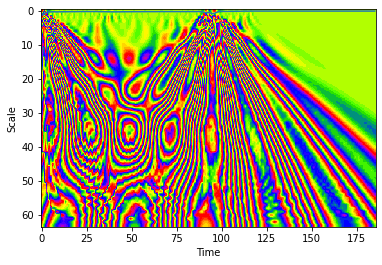

In [92]:
plt.plot(data.iloc[42,:-2])
scales = np.arange(1, 65) # range of scales
coeffs, freqs = pywt.cwt( data.iloc[42,:-2], scales, wavelet = "morl")
# create scalogram
plt.plot(figsize=(12,5))
plt.imshow(coeffs, cmap ='prism', aspect = 'auto')
# plt.set_title(name)
# plt.spines['right'].set_visible(False)
# plt.spines['top'].set_visible(False)
plt.ylabel('Scale')
plt.xlabel('Time')#4

Text(0.5, 0, 'Time')

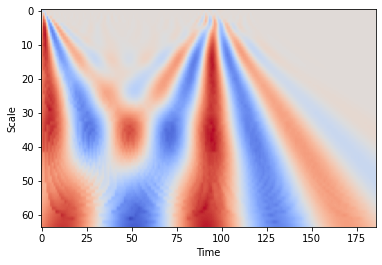

In [77]:
import pywt
import matplotlib.pyplot as plt
scales = np.arange(1, 65) # range of scales
coeffs, freqs = pywt.cwt( data.iloc[42,:-2], scales, wavelet = "morl")
# create scalogram
plt.plot(figsize=(12,5))
plt.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
# plt.set_title(name)
# plt.spines['right'].set_visible(False)
# plt.spines['top'].set_visible(False)
plt.ylabel('Scale')
plt.xlabel('Time')

In [6]:
def network(X_train,y_train,X_test,y_test):
    
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(32, (5), activation='relu', input_shape=im_shape)(inputs_cnn)
#     conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(5), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (10), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization(axis=-1,
    momentum=0.99,
    epsilon=0.001,)(conv2_1)
    pool2=MaxPool1D(pool_size=(10), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(256, (20), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization(axis=-1,
    momentum=0.99,
    epsilon=0.001,)(conv3_1)
    pool3=MaxPool1D(pool_size=(20), strides=(2), padding="same")(conv3_1)
    gru = tf.keras.layers.GRU(256,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), return_sequences=True)(pool3)
    gru2 = tf.keras.layers.GRU(64,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), return_sequences=True)(gru)
#     gru3 = tf.keras.layers.GRU(32, return_sequences=True)(gru2)
    flatten = tf.keras.layers.Flatten()(gru2)
    dense_end1 = Dense(32, activation='relu')(flatten)
    dense_end2 = Dense(16, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    opt = keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,)
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=512,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    print(model.summary())
    return(model,history)

def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    plt.figure(figsize=(8,6))
    plt.imshow(cnf_matrix, cmap="Oranges")
    plt.colorbar()
    classes=['N', 'S', 'V', 'F', 'Q']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.show()


def evaluate_metrics(confusion_matrix):
    # https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    # Specificity or true negative rate
    TNR = TN / (TN + FP)
    # Precision or positive predictive value
    PPV = TP / (TP + FP)
    # Negative predictive value
    NPV = TN / (TN + FN)
    # Fall out or false positive rate
    FPR = FP / (FP + TN)
    # False negative rate
    FNR = FN / (TP + FN)
    # False discovery rate
    FDR = FP / (TP + FP)

    # Overall accuracy
    ACC = (TP + TN) / (TP + FP + FN + TN)
    # ACC_micro = (sum(TP) + sum(TN)) / (sum(TP) + sum(FP) + sum(FN) + sum(TN))
    ACC_macro = np.mean(ACC) # to get a sense of effectiveness of our method on the small classes we computed this average (macro-average)

    return ACC_macro, ACC, TPR, TNR, PPV

In [29]:
from sklearn.metrics import f1_score
from keras.regularizers import l2

accu = []
Rec = []
F1= []
Prec = []
i = 0



while i <30:
    y = data['Label'].copy()
    X = data.drop('Label', axis=1).copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None )
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=None )

    X_train=X_train.values
    X_test=X_test.values
    X_val=X_val.values

    from imblearn.over_sampling import SMOTE
    oversample = SMOTE()
    X_train, y_train = oversample.fit_resample(X_train, y_train)

    X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
    X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
    X_val = X_val.reshape(len(X_val), X_val.shape[1],1)

    y_train=to_categorical(y_train)
    y_test=to_categorical(y_test)
    y_val = to_categorical(y_val)


    model,history=network(X_train,y_train,X_val,y_val)


    # evaluate_model(history,X_test,y_test,model)
    y_pred=model.predict(X_test)
    #   y_pred = model.predict_classes(X_test)
    accu.append(accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    #   ACC_macro, ACC, Sensitivity, Specificity, Precision = evaluate_metrics(confusion_matrix(y_test,y_pred))
    #   Sens.append(Sensitivity)
    #   Spec.append(Specificity)
    #   Prec.append(Precision)
    

    Prec.append(precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro'))
    Rec.append(recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro'))
    F1.append(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro'))
    # df.to_csv(f'GFG{i}.csv')
    print(i)
    i+=1
    



# dictionary of lists
dic = {'accu': accu, 'Rec': Rec, 'F1': F1,'Prec':Prec}

df = pd.DataFrame(dic)

# saving the dataframe
df.to_csv('cnn_rnn.csv')



Epoch 1/40
620/620 [==============================] - 71s 36ms/step - loss: 0.7869 - accuracy: 0.9390 - val_loss: 0.9273 - val_accuracy: 0.6105
Epoch 2/40
620/620 [==============================] - 21s 33ms/step - loss: 0.0876 - accuracy: 0.9790 - val_loss: 0.1259 - val_accuracy: 0.9655
Epoch 3/40
620/620 [==============================] - 20s 33ms/step - loss: 0.0604 - accuracy: 0.9862 - val_loss: 0.1170 - val_accuracy: 0.9681
Epoch 4/40
620/620 [==============================] - 20s 33ms/step - loss: 0.0504 - accuracy: 0.9892 - val_loss: 0.0965 - val_accuracy: 0.9755
Epoch 5/40
620/620 [==============================] - 20s 32ms/step - loss: 0.0445 - accuracy: 0.9905 - val_loss: 0.2222 - val_accuracy: 0.9346
Epoch 6/40
620/620 [==============================] - 20s 33ms/step - loss: 0.0427 - accuracy: 0.9913 - val_loss: 0.2257 - val_accuracy: 0.9428
Epoch 7/40
620/620 [==============================] - 20s 33ms/step - loss: 0.0380 - accuracy: 0.9925 - val_loss: 0.0966 - val_accuracy:

Accuracy: 98.68%


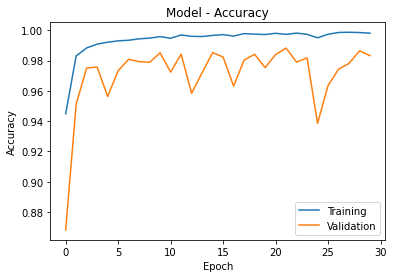

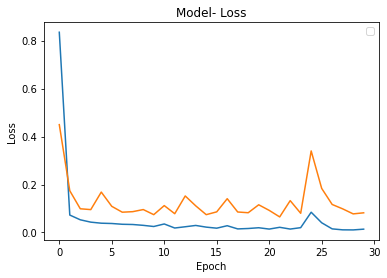

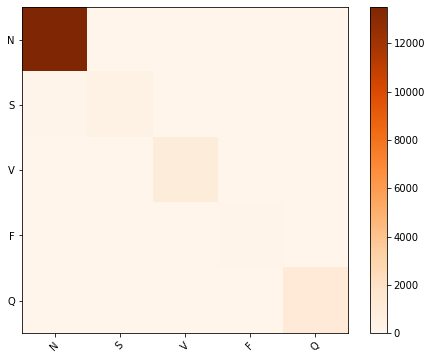

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

In [11]:
def network(X_train,y_train,X_test,y_test):
    
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(32, (5),kernel_regularizer=l2(0.0005),bias_regularizer=l2(0.0005),  activation='relu', input_shape=im_shape)(inputs_cnn)
#     conv1_1=BatchNormalization(axis=-1,
#     momentum=0.99,
#     epsilon=0.001,)(conv1_1)
    pool1=MaxPool1D(pool_size=(5), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (10),kernel_regularizer=l2(0.0005),bias_regularizer=l2(0.0005), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization(axis=-1,
    momentum=0.99,
    epsilon=0.001,)(conv2_1)
    pool2=MaxPool1D(pool_size=(10), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(256, (20),kernel_regularizer=l2(0.0005),bias_regularizer=l2(0.0005), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization(axis=-1,
    momentum=0.99,
    epsilon=0.001,)(conv3_1)
    pool3=MaxPool1D(pool_size=(20), strides=(2), padding="same")(conv3_1)
    gru = tf.keras.layers.GRU(256,kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001 ), bias_regularizer=l2(0.0001), return_sequences=True)(pool3)
    gru2 = tf.keras.layers.GRU(64,kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001 ), bias_regularizer=l2(0.0001), return_sequences=True)(gru)
#     gru3 = tf.keras.layers.GRU(32, return_sequences=True)(gru2)
    flatten = tf.keras.layers.Flatten()(gru2)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
#     dense_end3 = Dense(16, activation='relu')(dense_end2)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,)
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=512,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    print(model.summary())
    return(model,history)

def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    plt.figure(figsize=(8,6))
    plt.imshow(cnf_matrix, cmap="Oranges")
    plt.colorbar()
    classes=['N', 'S', 'V', 'F', 'Q']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.show()


def evaluate_metrics(confusion_matrix):
    # https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    # Specificity or true negative rate
    TNR = TN / (TN + FP)
    # Precision or positive predictive value
    PPV = TP / (TP + FP)
    # Negative predictive value
    NPV = TN / (TN + FN)
    # Fall out or false positive rate
    FPR = FP / (FP + TN)
    # False negative rate
    FNR = FN / (TP + FN)
    # False discovery rate
    FDR = FP / (TP + FP)

    # Overall accuracy
    ACC = (TP + TN) / (TP + FP + FN + TN)
    # ACC_micro = (sum(TP) + sum(TN)) / (sum(TP) + sum(FP) + sum(FN) + sum(TN))
    ACC_macro = np.mean(ACC) # to get a sense of effectiveness of our method on the small classes we computed this average (macro-average)

    return ACC_macro, ACC, TPR, TNR, PPV

from skimage.transform import resize

def create_cwt_images(X, n_scales, rescale_size, wavelet_name = "morl"):
    n_samples = X.shape[0] 
    n_signals = X.shape[2] 
    
    # range of scales from 1 to n_scales
    scales = np.arange(1, n_scales + 1) 
    
    # pre allocate array
    X_cwt = np.ndarray(shape=(n_samples, rescale_size, rescale_size, n_signals), dtype = 'float32')
    
    for sample in range(n_samples):
        if sample % 1000 == 0:
            print(sample)
        for signal in range(n_signals):
            serie = X[sample, :, signal]
            # continuous wavelet transform 
            coeffs, freqs = pywt.cwt(serie, scales, wavelet_name)
            # resize the 2D cwt coeffs
            rescale_coeffs = resize(coeffs, (rescale_size, rescale_size), mode = 'constant')
            X_cwt[sample,:,:,signal] = rescale_coeffs
            
    return X_cwt
  
# amount of pixels in X and Y 
rescale_size = 64
# determine the max scale size
n_scales = 64



In [13]:
from tensorflow.keras import regularizers
from keras.regularizers import l2
y = data['Label'].copy()
X = data.drop('Label', axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None )
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=None )

X_train=X_train.values
X_test=X_test.values
X_val=X_val.values

from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
X_val = X_val.reshape(len(X_val), X_val.shape[1],1)



y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_val = to_categorical(y_val)


model,history=network(X_train,y_train,X_val,y_val)


# evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)
#   y_pred = model.predict_classes(X_test)
accu.append(accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
#   ACC_macro, ACC, Sensitivity, Specificity, Precision = evaluate_metrics(confusion_matrix(y_test,y_pred))
#   Sens.append(Sensitivity)
#   Spec.append(Specificity)
#   Prec.append(Precision)


Prec.append(precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro'))
Rec.append(recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro'))
F1.append(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro'))

Epoch 1/40
619/619 [==============================] - 24s 34ms/step - loss: 0.2724 - accuracy: 0.9466 - val_loss: 1.6755 - val_accuracy: 0.4261
Epoch 2/40
619/619 [==============================] - 20s 33ms/step - loss: 0.1375 - accuracy: 0.9809 - val_loss: 0.2124 - val_accuracy: 0.9545
Epoch 3/40
619/619 [==============================] - 21s 33ms/step - loss: 0.1110 - accuracy: 0.9851 - val_loss: 0.2117 - val_accuracy: 0.9495
Epoch 4/40
619/619 [==============================] - 20s 33ms/step - loss: 0.0953 - accuracy: 0.9874 - val_loss: 0.2614 - val_accuracy: 0.9334
Epoch 5/40
619/619 [==============================] - 20s 32ms/step - loss: 0.0891 - accuracy: 0.9885 - val_loss: 0.1262 - val_accuracy: 0.9795
Epoch 6/40
619/619 [==============================] - 20s 33ms/step - loss: 0.0825 - accuracy: 0.9892 - val_loss: 0.3642 - val_accuracy: 0.9010
Epoch 7/40
619/619 [==============================] - 20s 33ms/step - loss: 0.0770 - accuracy: 0.9901 - val_loss: 0.1158 - val_accuracy:

NameError: name 'accu' is not defined

In [ ]:
from sklearn.metrics import f1_score
F1.append(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro'))

In [1]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

NameError: name 'evaluate_model' is not defined

In [12]:
def build_cnn_model(activation, input_shape):

    model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(5,5), strides=(2,2),kernel_regularizer=l2(0.0005),bias_regularizer=l2(0.0005), activation='relu', input_shape=(64, 64, 1)),
    keras.layers.BatchNormalization(axis=-1,
    momentum=0.99,
    epsilon=0.001,),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(4,4), strides=(1,1), kernel_regularizer=l2(0.0005),bias_regularizer=l2(0.0005),activation='relu', padding="same"),
    keras.layers.BatchNormalization(axis=-1,
    momentum=0.99,
    epsilon=0.001,),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), kernel_regularizer=l2(0.0005),bias_regularizer=l2(0.0005),activation='relu', padding="same"),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), kernel_regularizer=l2(0.0005),bias_regularizer=l2(0.0005),activation='relu', padding="same"),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), kernel_regularizer=l2(0.0005),bias_regularizer=l2(0.0005),activation='relu', padding="same"),

    keras.layers.BatchNormalization(axis=-1,
    momentum=0.99,
    epsilon=0.001,),
#     keras.layers.Conv2
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])
    
    # summarize the model
    print(model.summary())
    return model

def compile_and_fit_model(model, X_train, y_train, X_test, y_test, batch_size, n_epochs):

    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['categorical_crossentropy'])
    
    # define callbacks
    callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='categorical_crossentropy', save_best_only=True)]
    
    # fit the model
    history = model.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        verbose=1,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))
    
    return model, history

In [ ]:
import pywt
from tensorflow.keras import regularizers
from keras.regularizers import l2
y = data['Label'].copy()
X = data.drop('Label', axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None )
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=None )

X_train=X_train.values
X_test=X_test.values
X_val=X_val.values

from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
X_val = X_val.reshape(len(X_val), X_val.shape[1],1)

X_train = create_cwt_images(X_train, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: {X_train.shape}")
X_test = create_cwt_images(X_test, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: {X_test.shape}")
X_val = create_cwt_images(X_val, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: {X_val.shape}")


y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_val = to_categorical(y_val)

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

# create cnn model
cnn_model = build_cnn_model("relu", input_shape)
# train cnn model
trained_cnn_model, cnn_history = compile_and_fit_model(cnn_model, X_train, y_train, X_val, y_val, 256, 20)

y_pred = trained_cnn_model.predict_classes(X_test_cwt)
# determine the total accuracy 
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# # evaluate_model(history,X_test,y_test,model)
# y_pred=model.predict(X_test)
# #   y_pred = model.predict_classes(X_test)
# accu.append(accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
#   ACC_macro, ACC, Sensitivity, Specificity, Precision = evaluate_metrics(confusion_matrix(y_test,y_pred))
#   Sens.append(Sensitivity)
#   Spec.append(Specificity)
#   Prec.append(Precision)


# Prec.append(precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro'))
# Rec.append(recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro'))
# F1.append(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro'))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


2022-11-17 08:44:07.905361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 08:44:07.906535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 08:44:08.220742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 08:44:08.221718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 08:44:08.222550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 96)        2496      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 256)       393472    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 384)         8

2022-11-17 08:44:13.636448: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5191188480 exceeds 10% of free system memory.
2022-11-17 08:44:19.951580: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5191188480 exceeds 10% of free system memory.
2022-11-17 08:44:24.274688: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


In [ ]:
cnn_model = build_cnn_model("relu", input_shape)
# train cnn model
trained_cnn_model, cnn_history = compile_and_fit_model(cnn_model, X_train, y_train, X_val, y_val, 256, 20)

y_pred = trained_cnn_model.predict_classes(X_test)
# determine the total accuracy 
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))